# PixelCNN for FashionMNIST

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/05_autoregressive/02_pixelcnn/pixelcnn.ipynb)

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

import jax
import jax.numpy as jnp

from flax import linen as nn
from flax.training import train_state

import optax

## 0. Training Parameters

In [2]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 8
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 64
EPOCHS = 100

## 1. Preparing FashionMNIST dataset

In [3]:
# Turn input image into pixels and per-pixel labels
def preprocess(imgs):
    imgs = imgs['image']
    imgs_int = tf.image.resize(imgs, (IMAGE_SIZE, IMAGE_SIZE))
    imgs_int = tf.cast((imgs_int / (256 / PIXEL_LEVELS)), tf.int32)
    imgs = tf.cast(imgs_int, tf.float32)
    imgs = imgs / PIXEL_LEVELS
    return {'image': imgs, 'label': imgs_int}

# Get train/valid datasets
def get_datasets():
    train_ds, valid_ds = tfds.load('fashion_mnist', split=['train', 'test'])
    
    train_ds = train_ds.map(lambda sample: preprocess(sample))
    valid_ds = valid_ds.map(lambda sample: preprocess(sample))
    
    train_ds = train_ds.shuffle(1024).batch(BATCH_SIZE).prefetch(1)
    valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(1)
    return train_ds, valid_ds

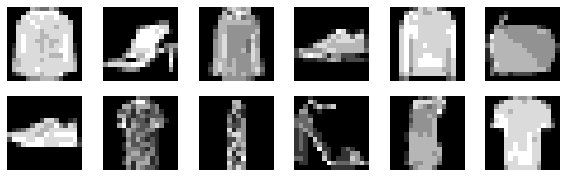

In [4]:
# Check dataset
def plot_imgs(batch, num_rows=2, num_cols=6):
    plt.figure(figsize=(10, 3))
    for i in range(num_cols * num_rows):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        ax.axis('off')
        ax.imshow(batch[i], cmap='gray')
    plt.show()

test_ds, _ = get_datasets()
test_batch = next(test_ds.as_numpy_iterator())['image']
plot_imgs(test_batch)

## 2. Build the PixelCNN

In [5]:
class MaskedConv2D(nn.Module):
    in_features: int # The number of input features
    out_features: int # The number of output features
    kernel_size: tuple
    mask_type: str
    padding: str

    def setup(self):
        assert self.mask_type in ['A', 'B'], 'Mask type should be either A or B'
        kh, kw = self.kernel_size

        # Generating mask -> shape (k, k)
        mask = jnp.ones(shape=self.kernel_size)
        mask = mask.at[kh // 2 + 1:,].set(0)
        mask = mask.at[kh // 2, kw // 2 + 1:].set(0)

        if self.mask_type == 'A':
            mask = mask.at[kh // 2, kw // 2].set(0)
            
        # Expanding and repeating the mask -> shape (k, k, in_features, out_features)
        mask = mask[:, :, None, None]
        mask = jnp.tile(mask, (1, 1, self.in_features, self.out_features))
        
        self.conv = nn.Conv(features=self.out_features, 
                            kernel_size=self.kernel_size, 
                            padding=self.padding, 
                            mask=mask)

    def __call__(self, x):
        return self.conv(x)

In [6]:
# # check masked conv
# masked_conv = MaskedConv2D(1, 128, (7, 7), 'A', 'same')
# print(masked_conv.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 16, 16, 1))))

In [7]:
# Building the residual block
class ResidualBlock(nn.Module):

    features:int
    
    def setup(self):

        self.conv_1 = nn.Sequential([
                        nn.Conv(features=self.features // 2, 
                              kernel_size=(1, 1),
                              strides=1),
                        nn.relu])
        
        self.pixel_conv = nn.Sequential([
                            MaskedConv2D(in_features=self.features // 2,
                                       out_features=self.features // 2,
                                       kernel_size=(3, 3),
                                       mask_type='B',
                                       padding='same'),
                            nn.relu])

        self.conv_2 = nn.Sequential([
                        nn.Conv(features=self.features,
                              kernel_size=(1, 1),
                              strides=1),
                        nn.relu])
    
    def __call__(self, x):
        conv_x = self.conv_1(x)
        conv_x = self.pixel_conv(conv_x)
        conv_x = self.conv_2(conv_x)
        return conv_x + x

In [8]:
# # Check residual block
# res_block = ResidualBlock(128) 
# print(res_block.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 16, 16, 128))))

In [9]:
class PixelCNN(nn.Module):
    
    num_filters:int
    num_res_blocks:int
    output_size:int
    
    def setup(self):
        self.masked_conv_1 = nn.Sequential([
                                MaskedConv2D(in_features=1, 
                                             out_features=self.num_filters,
                                             kernel_size=(7, 7),
                                             mask_type='A',
                                             padding='same'),
                                nn.relu])

        self.res_blocks = nn.Sequential([
                                ResidualBlock(self.num_filters) 
                                    for _ in range(self.num_res_blocks)])

        masked_conv_2_layers = []
        for _ in range(2):
            masked_conv_2_layers.append(MaskedConv2D(in_features=self.num_filters,
                                                out_features=self.num_filters,
                                                kernel_size=(1, 1),
                                                mask_type='B',
                                                padding='valid'))
            masked_conv_2_layers.append(nn.relu)

        self.masked_conv_2 = nn.Sequential(masked_conv_2_layers)

        self.output_conv = nn.Conv(features=self.output_size,
                                   kernel_size=(1, 1),
                                   padding='valid')
        

    def __call__(self, x):
        x = self.masked_conv_1(x)
        x = self.res_blocks(x)
        x = self.masked_conv_2(x)
        x = self.output_conv(x)
        return x

In [11]:
# check PixelCNN model
pixel_cnn = PixelCNN(N_FILTERS, RESIDUAL_BLOCKS, PIXEL_LEVELS)
print(pixel_cnn.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 16, 16, 1)), depth=2))


                                                  PixelCNN Summary                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path                   ┃ module        ┃ inputs               ┃ outputs              ┃ params                     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                        │ PixelCNN      │ float32[1,16,16,1]   │ float32[1,16,16,8]   │                            │
├────────────────────────┼───────────────┼──────────────────────┼──────────────────────┼────────────────────────────┤
│ masked_conv_1          │ Sequential    │ float32[1,16,16,1]   │ float32[1,16,16,128] │                            │
├────────────────────────┼───────────────┼──────────────────────┼──────────────────────┼────────────────────────────┤
│ masked_conv_1/layers_0 │ MaskedConv2D  │ float32[1,16